In [10]:
import sunpy.lightcurve
from sunpy.time import TimeRange
import matplotlib.pyplot as plt
%matplotlib notebook

In [11]:
date = "2017/09/06"

In [12]:
lyra = sunpy.lightcurve.LYRALightCurve.create(date)

<IPython.core.display.Javascript object>


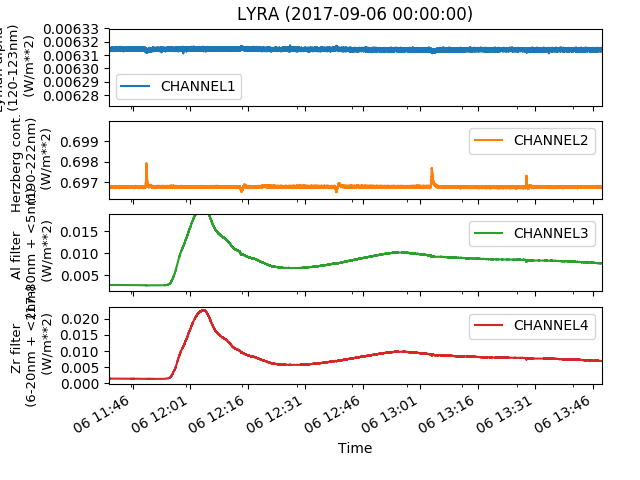

/home/marcus/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


In [13]:
lyra.peek()

In [16]:
goesxrs = sunpy.lightcurve.GOESLightCurve.create(TimeRange(date, "2017/09/07"))

<IPython.core.display.Javascript object>


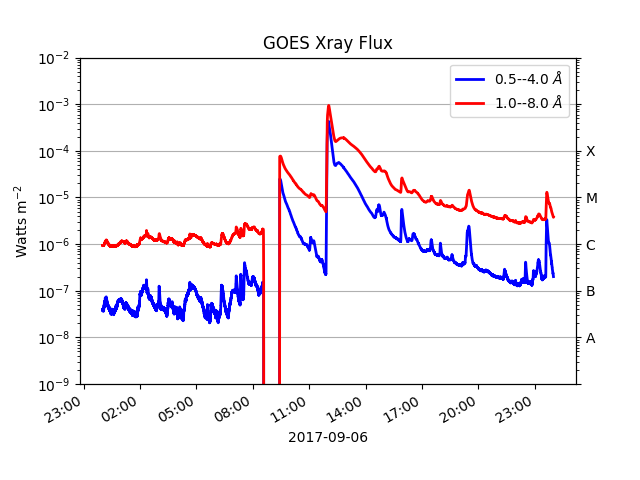

In [17]:
goesxrs.peek()

In [14]:
eve = sunpy.lightcurve.EVELightCurve.create(date)

<IPython.core.display.Javascript object>


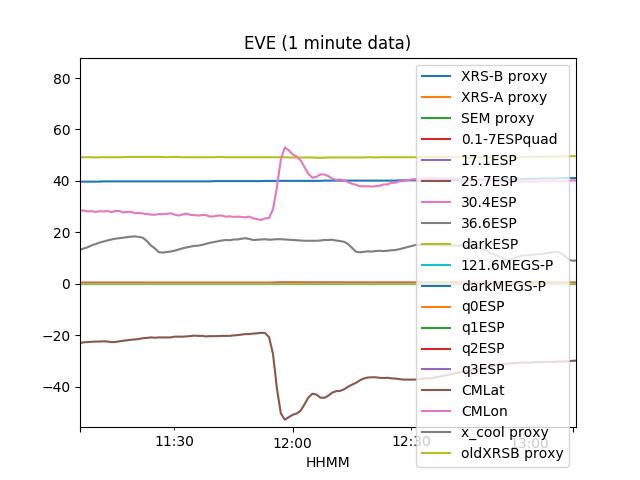

In [15]:
eve.peek()

In [45]:
from sunpy.net.vso import VSOClient
from sunpy.net.vso import attrs
from datetime import datetime
from astropy import units as u
from astropy.io import fits
import numpy as np

In [20]:
client = VSOClient()

In [27]:
results = client.search(attrs.Time(datetime(2017,9,6,10), datetime(2017,9,6,13)), 
                        attrs.Instrument('aia'), attrs.Wavelength(94 * u.angstrom))

In [76]:
results[500]

(QueryResponseBlock){
   physobs = "intensity"
   provider = "JSOC"
   info = "AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]"
   wave = 
      (Wave){
         waveunit = "Angstrom"
         wavemin = "94"
         wavemax = "94"
         wavetype = "NARROW"
      }
   instrument = "AIA"
   extent = 
      (Extent){
         length = "4096"
         width = "4096"
         type = "FULLDISK"
      }
   size = 66200.0
   fileid = "aia__lev1:94:1283773250"
   time = 
      (Time){
         start = "20170906114011"
         end = "20170906114012"
      }
   source = "SDO"
 }

In [81]:
fns = client.fetch(results[610:613]).wait()

[                                        ========================================


In [91]:
with fits.open(fns[1]) as hdu:
    hdu.verify('fix')
    head = hdu[1].header
    data = hdu[1].data
data = data.astype(float)
POWER = 1.0
data[data > 0] = np.power(data[data>0], POWER)
data[data < 0] = -np.power(np.abs(data[data<0]), POWER)

 [astropy.io.fits.verify]


In [92]:
head['exptime'], head['date-obs']

(2.902055, '2017-09-06T12:02:23.12')

<IPython.core.display.Javascript object>


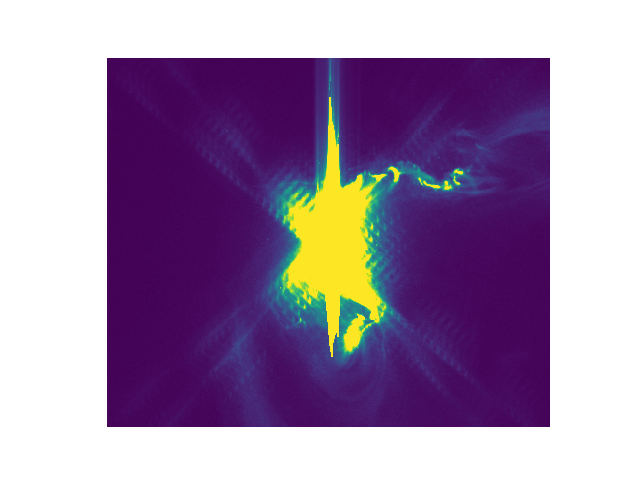

In [95]:
fig, ax = plt.subplots()
ax.imshow(data, origin='lower', vmin=0, vmax=1003)
ax.set_axis_off()
fig.show()

In [96]:
import urllib.request

In [97]:
url="https://hesperia.gsfc.nasa.gov/hessidata/dbase/hessi_flare_list.txt"

In [100]:
page = urllib.request.urlopen(url).read()

In [108]:
bb = page.decode("utf-8").split("\n")

In [109]:
len(bb[0])

47

In [114]:
bb[-42]

' 18030301  3-Mar-2018 04:04:08 04:06:22 04:12:20   492     42     15816        6-12   926   128    935 2700  A0 P1 PE Q1                       '

In [117]:
class ListHandler(ABC):
    def __init__(self, url=None):
        self.url = url
        self.contents = None

    @abstractmethod
    def load(self, path):
        pass

    @abstractmethod
    def fetch(self):
        pass

    @abstractmethod
    def save(self, path):
        pass


class RhessiListHandler(ListHandler):
    def __init__(self, url="https://hesperia.gsfc.nasa.gov/hessidata/dbase/hessi_flare_list.txt"):
        ListHandler.__init__(self, url)

    def fetch(self):
        """
        fetch the Rhessi table from the specified url and
        :return:
        """
        # fetch the page contents
        page = urllib.request.urlopen(self.url).read()
        lines = page.decode("utf-8").split("\n")
        start_line, end_line = 7, -41  # lines[7:-41] contain the table while everything else is comments

        FlareRecord = namedtuple("FlareRecord",
                                 ["number", "time_start", "time_peak", "time_end", "duration",
                                  "max_rate", "total_counts", "pos_x", "pos_y", "radial", "ar"])

        def process_line(line):
            """
            Process a single entry in the Rhessi table into a clean format
            :param line: a line in the rhessi table
            :type line: str
            :return: a clean record of the Rhessi table line with entries converted to the appropriate types,
                    e.g. dates are in DateTime and numbers are ints
            :rtype: FlareRecord
            """
            month_numbers = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
                             "Jul": 7,
                             "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
            entries = line.split()

            # the entry number
            number = int(entries[0])

            # process start date
            start_date = entries[1]
            start_time = entries[2]
            day, month, year = start_date.split("-")
            hour, minute, second = start_time.split(":")
            start = datetime(int(year), month_numbers[month], int(day), int(hour), int(minute), int(second))

            # process peak time
            peak_time = entries[3]
            hour, minute, second = peak_time.split(":")
            peak = datetime(int(year), month_numbers[month], int(day), int(hour), int(minute), int(second))

            # process end time
            end_time = entries[4]
            hour, minute, second = end_time.split(":")
            end = datetime(int(year), month_numbers[month], int(day), int(hour), int(minute), int(second))

            # process extra entry contents
            duration = int(entries[5])
            max_rate = int(entries[6])
            total = int(entries[7])
            energy = entries[8]
            pos_x = int(entries[9])
            pos_y = int(entries[10])
            radial = int(entries[11])
            ar = entries[12]
            return FlareRecord(number, start, peak, end, duration, max_rate, total, pos_x, pos_y, radial, ar)

        records = [process_line(line) for line in lines[start_line:end_line]]
        df = pd.DataFrame(records)
        self.contents = df
        return df
    
    
    def load(self, path):
        pass

    def save(self, path):
        pass

In [118]:
df = RhessiListHandler().fetch()

In [150]:
df.to_csv("/home/marcus/Desktop/test.csv", index=False, date_format="%Y-%m-%dT%H:%M:%S")

In [158]:
import dateutil

In [164]:
df2 = pd.read_csv("/home/marcus/Desktop/test.csv", parse_dates=True, date_parser=dateutil.parser.parse, skip_blank_lines=True)

In [ ]:
pd.Da

In [165]:
dfp

,number,time_start,time_peak,time_end,duration,max_rate,total_counts,pos_x,pos_y,radial,ar
0,2021213,2002-02-12 21:29:56,2002-02-12 21:33:38,2002-02-12 21:41:48,712,136,167304,592,-358,692,0
1,2021228,2002-02-12 21:44:08,2002-02-12 21:45:06,2002-02-12 21:48:56,288,7,9504,604,-341,694,9811
2,2021332,2002-02-13 00:53:24,2002-02-13 00:54:54,2002-02-13 00:57:00,216,15,11448,-310,375,487,9825
3,2021308,2002-02-13 04:22:52,2002-02-13 04:23:50,2002-02-13 04:26:56,244,20,17400,-277,378,469,9822
4,2021310,2002-02-13 07:03:52,2002-02-13 07:05:14,2002-02-13 07:07:48,236,336,313392,-272,390,476,9825
5,2021353,2002-02-13 07:07:48,2002-02-13 07:09:14,2002-02-13 07:20:56,788,272,524304,-271,389,474,9825
6,2021354,2002-02-13 07:20:56,2002-02-13 07:22:42,2002-02-13 07:30:04,548,28,52488,-267,390,473,9825
7,2021312,2002-02-13 08:53:20,2002-02-13 08:55:18,2002-02-13 09:05:08,708,92,125352,-362,309,476,0
8,2021339,2002-02-13 10:02:56,2002-02-13 10:04:42,2002-02-13 10:04:44,108,26,10368,-235,390,455,9822
9,2021313,2002-02-13 12:29:32,2002-02-13 12:30:58,2002-02-13 12:33:24,232,26,16920,-905,-375,980,0


In [171]:
dds = [dateutil.parser.parse(s) for s in df2['time_start'].values]

In [177]:
np.all(np.array([type(e) is datetime for e in dds]))

True

In [166]:
df2

,number,time_start,time_peak,time_end,duration,max_rate,total_counts,pos_x,pos_y,radial,ar
0,2021213,2002-02-12T21:29:56,2002-02-12T21:33:38,2002-02-12T21:41:48,712,136,167304,592,-358,692,0
1,2021228,2002-02-12T21:44:08,2002-02-12T21:45:06,2002-02-12T21:48:56,288,7,9504,604,-341,694,9811
2,2021332,2002-02-13T00:53:24,2002-02-13T00:54:54,2002-02-13T00:57:00,216,15,11448,-310,375,487,9825
3,2021308,2002-02-13T04:22:52,2002-02-13T04:23:50,2002-02-13T04:26:56,244,20,17400,-277,378,469,9822
4,2021310,2002-02-13T07:03:52,2002-02-13T07:05:14,2002-02-13T07:07:48,236,336,313392,-272,390,476,9825
5,2021353,2002-02-13T07:07:48,2002-02-13T07:09:14,2002-02-13T07:20:56,788,272,524304,-271,389,474,9825
6,2021354,2002-02-13T07:20:56,2002-02-13T07:22:42,2002-02-13T07:30:04,548,28,52488,-267,390,473,9825
7,2021312,2002-02-13T08:53:20,2002-02-13T08:55:18,2002-02-13T09:05:08,708,92,125352,-362,309,476,0
8,2021339,2002-02-13T10:02:56,2002-02-13T10:04:42,2002-02-13T10:04:44,108,26,10368,-235,390,455,9822
9,2021313,2002-02-13T12:29:32,2002-02-13T12:30:58,2002-02-13T12:33:24,232,26,16920,-905,-375,980,0


In [156]:
df2['time_start'][0] < datetime(1990, 12, 12, 12, 12, 12)

TypeError: '<' not supported between instances of 'str' and 'datetime.datetime'

In [161]:
df2['time_start'][0]

'2002-02-12T21:29:56'